In [3]:
import torch 
from torch import nn, optim,utils
from torchinfo import summary
import numpy as np

class NPDataset(utils.data.Dataset):

    def __init__(self, X):
        self.X = torch.tensor(X,dtype=torch.float)

    def __getitem__(self, item):
        return self.X[item]

    def __len__(self):
        return len(self.X)

def loss_function(x_hat, x, mu, log_var):
    BCE = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')

    # 2. KL-divergence
    # D_KL(Q(z|X) || P(z)); calculate in closed form as both dist. are Gaussian
    # here we assume that \Sigma is a diagonal matrix, so as to simplify the computation
    KLD = 0.5 * torch.sum(torch.exp(log_var) + torch.pow(mu, 2) - 1. - log_var)

    # 3. total loss
    loss = BCE + KLD
    return loss, BCE, KLD

class VAE(nn.Module):
    
    def __init__(self,input_dim, hidden_dim,z_dim):
        super(VAE,self).__init__()
        self.input_dim = input_dim
        self.fc1 = nn.Linear(input_dim,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, z_dim)
        self.fc3 = nn.Linear(hidden_dim,z_dim)
        
        self.fc4 = nn.Linear(z_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim,input_dim)
    
    def forward(self,x):
        batch_size = x.shape[0]
        x = x.view(batch_size,self.input_dim)
        mu,log_var = self.encode(x)
        z = self.reparameterization(mu,log_var)
        x_hat = self.decode(z)
        return x_hat, mu, log_var
    
    
    def encode(self,x):
        h = nn.functional.relu(self.fc1(x))
        mu = self.fc2(h)
        log_var = self.fc3(h)
        return mu, log_var
    
    def reparameterization(self, mu, log_var):
        sigma = torch.exp(log_var * 0.5)
        eps = torch.randn_like(sigma)
        return mu + sigma * eps  
    
    def decode(self,z):
        h = nn.functional.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))

class CVAE(nn.Module):
    def __init__(self, input_dim=28*28, middle_dim=400, latent_dim=20, class_num=10):
        super(CVAE, self).__init__()
        self.fc1 = nn.Linear(input_dim + class_num, middle_dim)
        self.fc_mu = nn.Linear(middle_dim, latent_dim)
        self.fc_logvar = nn.Linear(middle_dim, latent_dim)
        self.fc2 = nn.Linear(latent_dim + class_num, middle_dim)
        self.fc3 = nn.Linear(middle_dim, input_dim)
        self.recons_loss = nn.BCELoss(reduction='sum')
 
    def encode(self, x, labels):
        x = torch.cat((x, labels), dim=1)
        x = torch.relu(self.fc1(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
 
    def reparametrization(self, mu, logvar):
        # sigma = 0.5*exp(log(sigma^2))= 0.5*exp(log(var))
        std = torch.exp(logvar / 2)
        eps = torch.randn_like(std)
        # N(mu, std^2) = N(0, 1) * std + mu
        z = eps * std + mu
        return z
 
    def decode(self, z, labels):
        z = torch.cat((z, labels), dim=1)
        x = torch.relu(self.fc2(z))
        x = nn.functional.sigmoid(self.fc3(x))
        return x
 
    def forward(self, x, labels):
        mu, logvar = self.encode(x, labels)
        z = self.reparametrization(mu, logvar)
        x_hat = self.decode(z, labels)
        return x_hat,mu,logvar
        
        
model = VAE(28*28,256,64)
print(summary(model, input_size=(16, 28*28)))
# model(torch.rand((16,128)))       


Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [16, 784]                 --
├─Linear: 1-1                            [16, 256]                 200,960
├─Linear: 1-2                            [16, 64]                  16,448
├─Linear: 1-3                            [16, 64]                  16,448
├─Linear: 1-4                            [16, 256]                 16,640
├─Linear: 1-5                            [16, 784]                 201,488
Total params: 451,984
Trainable params: 451,984
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 7.23
Input size (MB): 0.05
Forward/backward pass size (MB): 0.18
Params size (MB): 1.81
Estimated Total Size (MB): 2.04


In [29]:
import tqdm
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
tlp = "/Users/john/data/test"
batch_size,dim=16,28*28
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root=f'{tlp}/mnist', train=True, download=True, transform=transform)  
# values = transforms.ToTensor()(train_dataset.train_data.numpy())
# mean,std=values.mean(),values.std()
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
epochs=5
model = VAE(28*28,256,64)
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-06)
for epoch in range(epochs):
    model.train()
    train_epoch_loss=[]
    for idx, (x,label) in tqdm.tqdm(enumerate(train_loader)):
        x = x.view((x.shape[0],-1))
        x_hat, mu, log_var = model(x)  # 模型的输出，在这里会自动调用model中的forward函数
        loss, BCE, KLD = loss_function(x_hat, x, mu, log_var)
        train_epoch_loss.append(loss.item())
        optimizer.zero_grad()  # 梯度清零，否则上一步的梯度仍会存在
        loss.backward()  # 后向传播计算梯度，这些梯度会保存在model.parameters里面
        optimizer.step()
    train_loss = np.average(train_epoch_loss)
    print(f"[Epoch {epoch}/{epochs}] [loss: {train_loss}]")

3750it [00:37, 99.95it/s] 


[Epoch 0/5] [loss: 2529.106137923177]


3750it [00:38, 97.43it/s] 


[Epoch 1/5] [loss: 2340.8061916992187]


3750it [00:45, 82.25it/s]


[Epoch 2/5] [loss: 2312.836791731771]


3750it [00:46, 81.38it/s] 


[Epoch 3/5] [loss: 2308.734150488281]


3750it [00:43, 87.00it/s] 

[Epoch 4/5] [loss: 2304.562936783854]


In [38]:
import tqdm
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
tlp = "/Users/john/data/test"
batch_size,dim=16,28*28
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root=f'{tlp}/mnist', train=True, download=True, transform=transform)  
# values = transforms.ToTensor()(train_dataset.train_data.numpy())
# mean,std=values.mean(),values.std()
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
epochs=5
model = CVAE(28*28,256,20)
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-06)
for epoch in range(epochs):
    model.train()
    train_epoch_loss=[]
    for idx, (x,labels) in tqdm.tqdm(enumerate(train_loader)):
        x = x.view((x.shape[0],-1))
        labels = nn.functional.one_hot(labels, num_classes=10)
        x_hat, mu, log_var = model(x,labels)  # 模型的输出，在这里会自动调用model中的forward函数
        loss, BCE, KLD = loss_function(x_hat, x, mu, log_var)
        train_epoch_loss.append(loss.item())
        optimizer.zero_grad()  # 梯度清零，否则上一步的梯度仍会存在
        loss.backward()  # 后向传播计算梯度，这些梯度会保存在model.parameters里面
        optimizer.step()
    train_loss = np.average(train_epoch_loss)
    print(f"[Epoch {epoch}/{epochs}] [loss: {train_loss}]")

3750it [00:49, 75.63it/s] 


[Epoch 0/5] [loss: 2209.0535588541666]


3750it [00:48, 77.08it/s] 


[Epoch 1/5] [loss: 1802.8241555013021]


3750it [00:40, 91.98it/s] 


[Epoch 2/5] [loss: 1734.4824333984375]


3750it [00:37, 99.22it/s] 


[Epoch 3/5] [loss: 1706.9995926106772]


3750it [00:36, 103.54it/s]

[Epoch 4/5] [loss: 1690.367350813802]


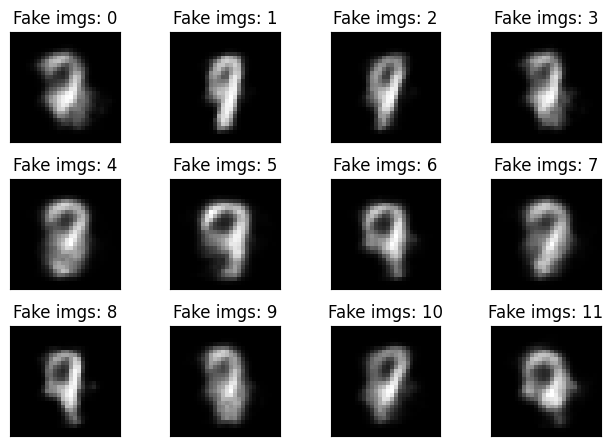

In [32]:
from matplotlib import pyplot as plt

def to_img(x):
    out = (x.clamp(0, 1)*256).to(torch.int32)
    out = out.view(-1, 28, 28)
    return out

# imgs = to_img(x_hat)
fimgs = model.decode(torch.rand(12,64))
imgs = to_img(fimgs)
fig = plt.figure()
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.tight_layout()
    plt.imshow(imgs[i].detach().numpy(), cmap='gray', interpolation='none')
    plt.title(f"Fake imgs: {i}")
    plt.xticks([])
    plt.yticks([])
plt.show()

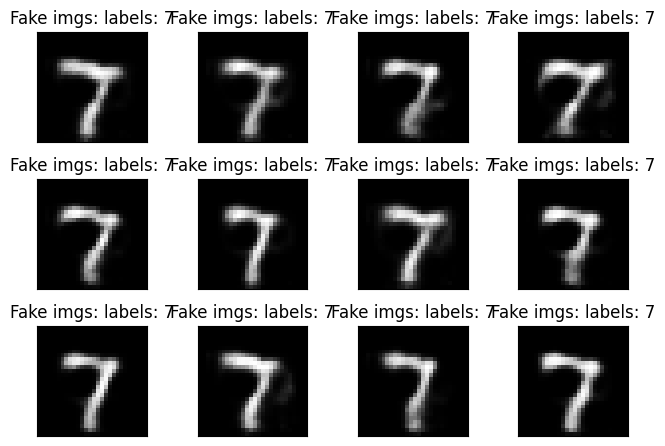

In [55]:
from matplotlib import pyplot as plt

def to_img(x):
    out = (x.clamp(0, 1)*256).to(torch.int32)
    out = out.view(-1, 28, 28)
    return out

# imgs = to_img(x_hat)
label = 7
flabels = nn.functional.one_hot(torch.tensor([label]*12),10)
fimgs = model.decode(torch.rand(12,64),flabels)
imgs = to_img(fimgs)
fig = plt.figure()
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.tight_layout()
    plt.imshow(imgs[i].detach().numpy(), cmap='gray', interpolation='none')
    plt.title(f"Fake imgs: labels: {label}")
    plt.xticks([])
    plt.yticks([])
plt.show()